####Problem Statement: Our objective is to determine whether a given cucumber plant or cucumber leaf is afflicted with disease or in a healthy state.

I have uploaded my dataset to Google Drive, and it is classified into four categories:

(i) Cucumber plants affected by disease

(ii) Healthy Cucumber plants

(iii) Cucumber leaves affected by disease

(iv) Healthy Cucumber leaves.

In [1]:

from google.colab import drive
from glob import glob
import tensorflow as tf
!pip install --upgrade tensorflow
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np

from tensorflow.keras.preprocessing import image
from keras.optimizers import Adam
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

drive.mount('/content/gdrive/', force_remount=True)
# %cd gdrive/MyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive/


In our dataset, we have 3 folders
train, val, test

In [2]:
data = glob('/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/*')
data

['/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/val',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/test']

The training dataset contains 2194 images of 4 classes mentioned above which are used to train the model

In [3]:
train_classes = glob('/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/*')
train_classes

['/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/Fresh_Cucumber_Plant',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/Diseased_Cucumber_Leaf',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/Diseased_Cucumber_Plant',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/Fresh_Cucumber_Leaf']

Validation_data: it contains images of 4 classes, these images used for validating the trained model

In [4]:
val_classes = glob('/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/val/*')
val_classes

['/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/val/Diseased_Cucumber_Leaf',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/val/Fresh_Cucumber_Plant',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/val/Fresh_Cucumber_Leaf',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/val/Diseased_Cucumber_Plant']

Test data: these images used to test the trained model

In [5]:
test_classes = glob('/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/test/*')
test_classes

['/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/test/Diseased_Cucumber_Leaf',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/test/Fresh_Cucumber_Plant',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/test/Diseased_Cucumber_Plant',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/test/Fresh_Cucumber_Leaf']

####Data Augmentation : Data augmentation is a method used to generate additional training data by applying specific techniques related to the domain. It involves manipulating existing training examples to create new and diverse training examples.

In production, we cannot predict the exact type of images we will receive from users. These images may be tilted, zoomed in, stretched, or flipped. To ensure effective classification of various types of images, it is necessary to apply data augmentation techniques to the training classes. This allows us to artificially create diverse variations of the training data that resemble the potential variations in the user-provided images.

we have used the ImageDataGenerator module for data augmentation

In [6]:
train_augment = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                fill_mode='nearest',
                                                                horizontal_flip=True,
                                                                shear_range=0.2,
                                                                zoom_range=0.2
)

train_augment_set = train_augment.flow_from_directory(
    '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)
    

Found 2129 images belonging to 4 classes.


The dataset consists of 1951 images that will be used to train the model. The input image size is set to 224 x 224 pixels, indicated by the target_size parameter. The images in the dataset are in color and represented in RGB format.

When accessing train_agumented_set[0][0][0], it returns a three-dimensional array. This array contains the values for the red (R), green (G), and blue (B) channels, representing the RGB values of the pixel at the specified location.

The flow_from_directory() method allows you to read the images directly from the directory and augment them while the neural network model is learning on the training data



This is the function which gives us the augmented images

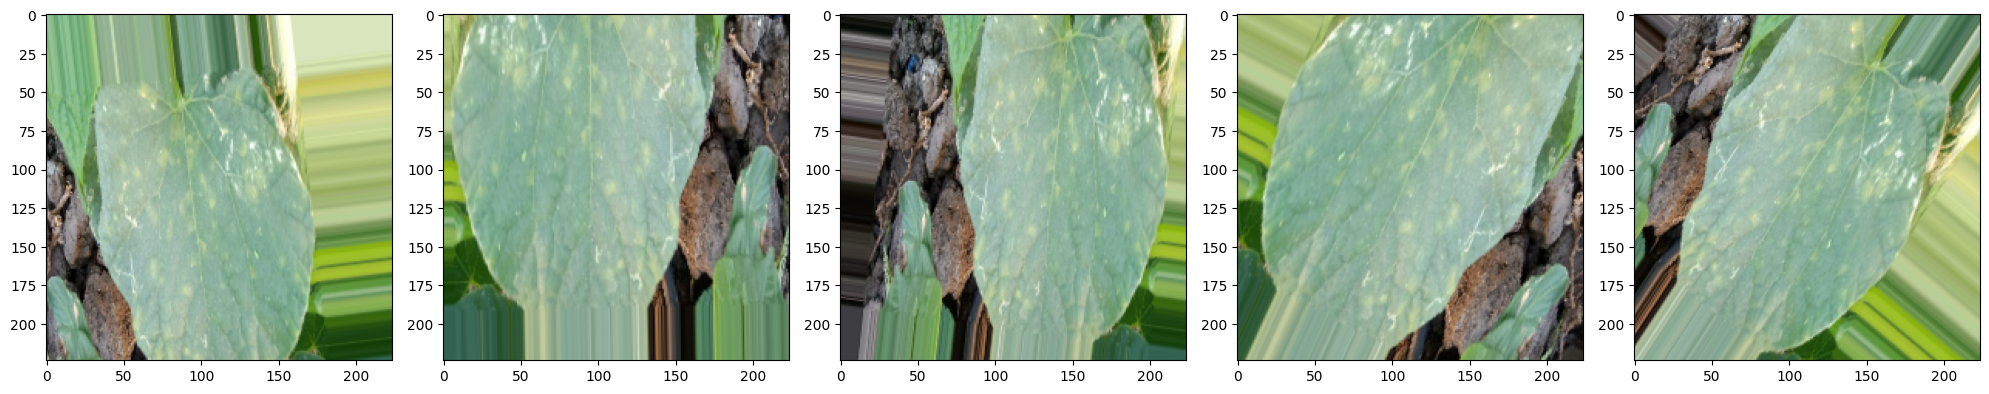

In [7]:
def plotImage(images):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img,ax in zip(images, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

images = [train_augment_set[0][0][0] for i in range (5)]
plotImage(images)


In [8]:
val_augment = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                              rotation_range=40,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2,
                                                              fill_mode='nearest',
                                                              horizontal_flip=True,
                                                              shear_range=0.2,
                                                              zoom_range=0.2)
                                 
val_augment_set = val_augment.flow_from_directory(
    '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/val/',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 697 images belonging to 4 classes.


We have 697 images in the validation data set



As mentioned before we have 4 classes for our training data 

0: Diseased Cucumber leaf

1:Diseased Cucumber plant

2: Fresh Cucumber leaf

3: Fresh Cucumber plant

In [9]:
train_augment_set.class_indices

{'Diseased_Cucumber_Leaf': 0,
 'Diseased_Cucumber_Plant': 1,
 'Fresh_Cucumber_Leaf': 2,
 'Fresh_Cucumber_Plant': 3}

#####Building CNN From Scratch :

We import the required modules for our multiclass classification problem using Keras with TensorFlow as the backend. The architecture of our model includes the following layers:

1Convolutional Layer: with a kernel size of 3 x 3 and 32 kernels.
2MaxPooling2D Layer: with a pool size of 2 x 2.
Convolutional Layer: with a kernel size of 3 x 3 and 64 kernels.
MaxPooling2D Layer: with a pool size of 2 x 2.
Convolutional Layer: with a kernel size of 3 x 3 and 128 kernels.
MaxPooling2D Layer: with a pool size of 2 x 2.
Convolutional Layer: with a kernel size of 3 x 3 and 256 kernels.
MaxPooling2D Layer: with a pool size of 2 x 2.
Dropout Layer: with a dropout rate of 0.5 for regularization.
Flatten Layer: to flatten the output of the previous layer.
Dense Layer: with 128 units and ReLU activation function.
Dropout Layer: with a dropout rate of 0.1.
Dense Layer: with 256 units and ReLU activation function.
Dropout Layer: with a dropout rate of 0.25.
Dense Layer: with the number of units equal to the number of classes (4) and softmax activation function, serving as the output layer for multiclass classification.
We utilize the Keras library with TensorFlow backend for implementing this model architecture.








Steps for building a Convolution neural network in Keras
1.  Building model: Defining Architecture
2.  Compile: Giving metadata(like loss, optimizer, etc)
3. Fit the model

Step 1: Building the model 

In [10]:
cnn_model = keras.models.Sequential([
                                    keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=[224, 224, 3]),
                                    keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    keras.layers.Conv2D(filters=64, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    keras.layers.Conv2D(filters=128, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    keras.layers.Conv2D(filters=256, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    
                                    keras.layers.Dropout(0.5),
                                    keras.layers.Flatten(), # neural network beulding
                                    keras.layers.Dense (units=128, activation='relu'), # input layers
                                    keras.layers.Dropout(0.1),
                                    keras.layers.Dense(units=256, activation='relu'),
                                    keras.layers.Dropout(0.25),
                                    keras.layers.Dense (units=4, activation='softmax') # output Layer
])
    

Step2: Compilation

In [11]:
cnn_model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

step3: Fit the model
We have fit the model for 10 epochs

In [13]:
history = cnn_model.fit(train_augment_set,
                        epochs=10,
                        verbose=1,
                        validation_data= val_augment_set
                        )

Epoch 1/10
67/67 [==============================] - 719s 11s/step - loss: 0.8653 - accuracy: 0.6529 - val_loss: 1.4675 - val_accuracy: 0.3773
Epoch 2/10
67/67 [==============================] - 157s 2s/step - loss: 0.5744 - accuracy: 0.7839 - val_loss: 1.0626 - val_accuracy: 0.5911
Epoch 3/10
67/67 [==============================] - 150s 2s/step - loss: 0.4315 - accuracy: 0.8417 - val_loss: 1.1494 - val_accuracy: 0.5538
Epoch 4/10
67/67 [==============================] - 150s 2s/step - loss: 0.3799 - accuracy: 0.8544 - val_loss: 1.0396 - val_accuracy: 0.6040
Epoch 5/10
67/67 [==============================] - 149s 2s/step - loss: 0.3530 - accuracy: 0.8666 - val_loss: 0.9058 - val_accuracy: 0.6758
Epoch 6/10
67/67 [==============================] - 149s 2s/step - loss: 0.3474 - accuracy: 0.8671 - val_loss: 0.9165 - val_accuracy: 0.6356
Epoch 7/10
67/67 [==============================] - 151s 2s/step - loss: 0.2995 - accuracy: 0.8891 - val_loss: 1.0774 - val_accuracy: 0.6212
Epoch 8/10
6

At the end of the 10th epoch

training_data_set_accuracy = 0.88

Valdation_data_set_accuracy=0.67



###Epoch vs Loss :

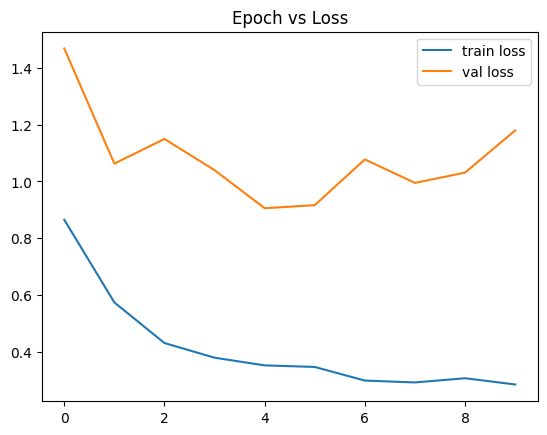

<Figure size 640x480 with 0 Axes>

In [14]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Epoch vs Loss")
plt.show()
plt.savefig('LossVal_loss')

###Epoch Vs Accuracy

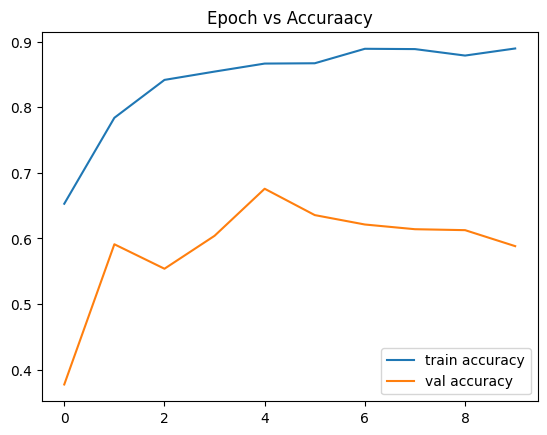

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title("Epoch vs Accuraacy")
plt.show()
plt.savefig('AccVal_acc')

####Model Evaluation:

To evaluate the trained model we use Validation data set class images



In [16]:
y_prediction = cnn_model.predict(val_augment_set)
y_prediction

22/22 [==============================] - 46s 2s/step


array([[0.00374405, 0.03254482, 0.58765376, 0.37605742],
       [0.8752147 , 0.07245915, 0.01494031, 0.03738585],
       [0.9896443 , 0.00345618, 0.00354651, 0.00335297],
       ...,
       [0.19932058, 0.63811815, 0.00500557, 0.15755571],
       [0.03539507, 0.18651584, 0.07118583, 0.7069032 ],
       [0.17481634, 0.00147271, 0.8223887 , 0.00132235]], dtype=float32)

In [17]:
val_augment_set.class_indices

{'Diseased_Cucumber_Leaf': 0,
 'Diseased_Cucumber_Plant': 1,
 'Fresh_Cucumber_Leaf': 2,
 'Fresh_Cucumber_Plant': 3}

Predicting the class of validation data set images
In the validation dataset, we have 324 images

Using trained CNN model we predicting the class of individual image

In [18]:
y_prediction = np.argmax(y_prediction, axis=1)
y_prediction

array([2, 0, 0, 3, 0, 3, 0, 0, 3, 2, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 2, 3,
       0, 2, 0, 0, 2, 0, 2, 2, 3, 0, 2, 3, 0, 0, 1, 3, 0, 3, 0, 2, 3, 2,
       2, 3, 0, 0, 3, 2, 2, 0, 0, 1, 3, 2, 3, 1, 0, 0, 0, 2, 1, 2, 0, 3,
       2, 0, 3, 0, 2, 0, 2, 2, 2, 3, 0, 0, 1, 2, 0, 2, 0, 0, 0, 2, 3, 2,
       0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 3, 2, 3, 2, 0, 3,
       2, 0, 0, 2, 2, 3, 0, 2, 0, 2, 3, 2, 2, 1, 2, 2, 0, 0, 0, 2, 0, 0,
       0, 2, 2, 0, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 0, 2, 0, 2, 2, 0, 2, 0,
       3, 0, 2, 0, 0, 3, 0, 2, 3, 0, 3, 3, 0, 3, 3, 0, 3, 0, 2, 3, 0, 0,
       2, 2, 0, 3, 3, 3, 3, 0, 0, 2, 0, 0, 1, 0, 2, 2, 0, 3, 0, 1, 0, 2,
       0, 2, 0, 2, 2, 2, 2, 0, 2, 3, 0, 2, 0, 0, 1, 3, 0, 0, 3, 2, 1, 2,
       0, 2, 3, 1, 2, 2, 2, 0, 0, 3, 0, 1, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2,
       2, 0, 2, 2, 0, 0, 0, 3, 0, 2, 0, 3, 0, 0, 3, 0, 2, 0, 3, 2, 2, 0,
       3, 3, 2, 0, 3, 2, 0, 3, 2, 2, 0, 2, 2, 0, 0, 3, 3, 0, 0, 3, 2, 2,
       3, 0, 2, 2, 2, 2, 2, 0, 2, 0, 3, 3, 2, 2, 0,

####Testing Trained Model Using Test Data Set Images

In [19]:

cnn_model.save("Cnn.h5")
model=load_model('Cnn.h5')

Loading saved model

In [20]:
img = image.load_img('/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/test/Diseased_Cucumber_Plant/test_img_2.jpeg', target_size=(224,224), color_mode="rgb")
x = image.img_to_array(img)
img_array = np.expand_dims(x, axis=0)


####Predicting the class of loaded image

In [21]:
img_array

array([[[[ 88.,  81.,  73.],
         [ 87.,  83.,  71.],
         [ 92.,  86.,  70.],
         ...,
         [111.,  94.,  68.],
         [110.,  92.,  68.],
         [112.,  94.,  72.]],

        [[ 87.,  83.,  72.],
         [ 88.,  85.,  70.],
         [ 91.,  88.,  69.],
         ...,
         [103.,  88.,  65.],
         [101.,  86.,  65.],
         [100.,  85.,  64.]],

        [[ 94.,  91.,  74.],
         [ 87.,  84.,  67.],
         [ 87.,  84.,  65.],
         ...,
         [ 88.,  77.,  55.],
         [ 82.,  74.,  53.],
         [ 82.,  74.,  53.]],

        ...,

        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [255., 235., 210.],
         [255., 233., 207.],
         [254., 232., 211.]],

        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [255., 235., 211.],
         [255., 232., 205.],
         [254., 234., 210.]],

        [[254., 254., 254.],
       

In [22]:
img_array = img_array/255.0


In [23]:
model.predict(img_array)

1/1 [==============================] - 0s 304ms/step


array([[0.04306073, 0.8016715 , 0.017209  , 0.13805881]], dtype=float32)

In [24]:
a = np.argmax(model.predict(img_array),axis=1)

1/1 [==============================] - 0s 20ms/step


In [25]:
a

array([1])


(vi) Transfer Learning :
Transfer learning is the reuse of a pre-trained model on a new problem. It’s currently very popular in deep learning because it can train deep neural networks with comparatively little data.

Famous Pretained Models

(i) Resnet50 : 25,636,712 parameters

(ii) Resnet152V2 : 60,380,648 parameters

(iii) InceptionV3 : 23,851,784 parameters

I choose InceptionV3 because it has fewer parameters compared to other models, fewer parameters leads to less time to response



In [26]:
Image_size = [224, 224]
transfer_model = InceptionV3(input_shape=Image_size + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [27]:
for layer in transfer_model.layers:
  layer.trainable = False

In [28]:
no_of_classes=glob('/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/*')

In [29]:
no_of_classes

['/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/Fresh_Cucumber_Plant',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/Diseased_Cucumber_Leaf',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/Diseased_Cucumber_Plant',
 '/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/train/Fresh_Cucumber_Leaf']

In [30]:
Bottle_neck_Output = Flatten()(transfer_model.output)
output_layer = Dense(len(no_of_classes), activation = 'softmax')(Bottle_neck_Output)
transfer_learning_model = Model(inputs=transfer_model.input, outputs = output_layer)

In [31]:
transfer_learning_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 alization)                     )                                                             

In [32]:
transfer_learning_model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [35]:
result = transfer_learning_model.fit_generator(
    train_augment_set,
    validation_data = val_augment_set,
    epochs = 10,
    steps_per_epoch=len(train_augment_set),
    validation_steps = len(val_augment_set)
)

<ipython-input-35-50bb0c67c03b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = transfer_learning_model.fit_generator(


Epoch 1/10
67/67 [==============================] - 203s 3s/step - loss: 1.4234 - accuracy: 0.8694 - val_loss: 2.2385 - val_accuracy: 0.7676
Epoch 2/10
67/67 [==============================] - 158s 2s/step - loss: 0.5292 - accuracy: 0.9394 - val_loss: 1.5765 - val_accuracy: 0.8379
Epoch 3/10
67/67 [==============================] - 157s 2s/step - loss: 0.5533 - accuracy: 0.9436 - val_loss: 1.2447 - val_accuracy: 0.8666
Epoch 4/10
67/67 [==============================] - 192s 3s/step - loss: 0.6009 - accuracy: 0.9418 - val_loss: 4.5512 - val_accuracy: 0.7762
Epoch 5/10
67/67 [==============================] - 192s 3s/step - loss: 0.6141 - accuracy: 0.9530 - val_loss: 1.4531 - val_accuracy: 0.8766
Epoch 6/10
67/67 [==============================] - 156s 2s/step - loss: 0.5927 - accuracy: 0.9502 - val_loss: 4.9700 - val_accuracy: 0.7532
Epoch 7/10
67/67 [==============================] - 187s 3s/step - loss: 0.6608 - accuracy: 0.9563 - val_loss: 3.7665 - val_accuracy: 0.8106
Epoch 8/10
67

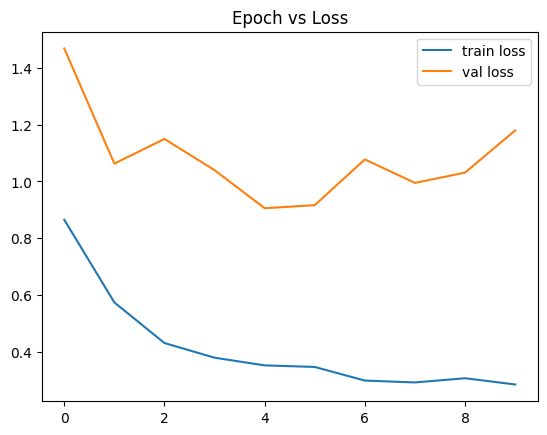

<Figure size 640x480 with 0 Axes>

In [36]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Epoch vs Loss")
plt.show()
plt.savefig('LossVal_loss')

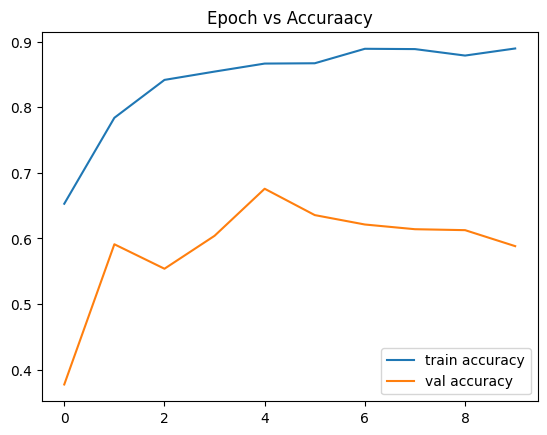

<Figure size 640x480 with 0 Axes>

In [37]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title("Epoch vs Accuraacy")
plt.show()
plt.savefig('AccVal_acc')

In [38]:
y_prediction = transfer_learning_model.predict(val_augment_set)

22/22 [==============================] - 47s 2s/step


In [39]:
y_prediction

array([[1.00000000e+00, 9.15213311e-27, 9.56505541e-10, 1.66490222e-21],
       [0.00000000e+00, 1.74207435e-30, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.72950276e-18, 0.00000000e+00, 1.00000000e+00],
       ...,
       [4.77951741e-37, 9.98971224e-01, 0.00000000e+00, 1.02877722e-03],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 5.31605683e-20],
       [0.00000000e+00, 1.05602815e-17, 1.17690854e-38, 1.00000000e+00]],
      dtype=float32)

In [40]:
y_prediction = np.argmax(y_prediction, axis=1)

In [41]:
y_prediction

array([0, 2, 3, 1, 2, 1, 1, 0, 0, 3, 3, 0, 0, 3, 0, 2, 1, 2, 3, 1, 1, 1,
       1, 1, 2, 1, 1, 3, 2, 2, 1, 0, 3, 0, 1, 0, 1, 3, 2, 2, 2, 2, 1, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 3, 1, 2, 3, 2, 0, 3, 0, 1, 2, 1, 3, 1, 2,
       0, 1, 1, 2, 1, 3, 1, 3, 3, 1, 1, 2, 3, 3, 1, 3, 1, 1, 1, 1, 0, 3,
       1, 0, 1, 3, 0, 2, 3, 0, 2, 3, 0, 0, 2, 1, 3, 2, 3, 2, 3, 3, 0, 3,
       2, 0, 2, 2, 2, 3, 1, 2, 3, 3, 3, 0, 1, 3, 0, 2, 3, 0, 3, 1, 1, 3,
       1, 1, 2, 2, 3, 3, 2, 2, 3, 1, 1, 1, 1, 2, 2, 0, 3, 2, 1, 1, 2, 3,
       2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 1, 3, 2, 1, 3, 3, 0, 3, 1, 3,
       1, 1, 2, 2, 3, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 3, 2, 2, 0, 3, 2, 2,
       1, 3, 2, 2, 3, 3, 3, 2, 0, 1, 1, 1, 1, 1, 2, 3, 1, 2, 2, 1, 2, 2,
       0, 1, 2, 3, 0, 0, 2, 0, 2, 3, 3, 1, 2, 2, 3, 0, 1, 3, 3, 1, 3, 0,
       0, 2, 3, 2, 2, 1, 2, 2, 2, 0, 3, 3, 1, 0, 1, 2, 1, 1, 2, 1, 2, 0,
       0, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1, 0, 0, 2, 1, 2, 2, 2, 3, 1, 0, 2,
       2, 1, 0, 3, 2, 1, 1, 0, 3, 2, 3, 1, 2, 0, 1,

In [48]:
transfer_learning_model.save('inception.h5')
incept=load_model('inception.h5')

####Predicting the class of loaded image

In [46]:
img1 = image.load_img('/content/gdrive/MyDrive/DL_Final/Agricultural-crops/Cucumber/test/Diseased_Cucumber_Leaf/test_img_2.jpeg', target_size=(224,224), color_mode="rgb")
y = image.img_to_array(img1)

y=y/255
img_array = np.expand_dims(y, axis=0)
img_data = preprocess_input(img_array)
img_data.shape


(1, 224, 224, 3)

In [47]:
prediction = incept.predict(img_data)

1/1 [==============================] - 2s 2s/step


In [49]:
prediction

array([[9.8430437e-01, 1.5650894e-02, 6.7330511e-06, 3.7970316e-05]],
      dtype=float32)

In [50]:
class_img = np.argmax(prediction, axis=1)

In [51]:
class_img

array([0])